## ResNet50 Model

For this notebook the ResNet50 pretrained model will be used to try to predict the 8 categories of images.


### 0. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [ ]:
train_dir = './labeled-images/train'
test_dir = './labeled-images/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 5752 files belonging to 8 classes.
Using 4602 files for training.
Found 5752 files belonging to 8 classes.
Using 1150 files for validation.
Found 640 files belonging to 8 classes.


### 02. Model architecture

Loading of pretrained ResNet50 model with imagenet and creation of the architecture.

In [ ]:
pretrained = ResNet50(weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))

# Since we have 8 categories, the last layer must contain 8 outputs
model.add(Dense(8))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 256)               42467584  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 activation (Activation)     (None, 8)                 0

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./labeled-images/train/')
cat_list.sort()

lenghts = [len(os.listdir('./labeled-images/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
[239, 264, 1447, 256, 115, 209, 2585, 637]
[4.906118628814432, 4.6679760067935225, 1.9949937343260002, 4.740253157796532, 7.07248188403477, 5.2459508194416005, 1.493318452306808, 3.004995840263344]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

The number of epochs was set at 100 in order to appreciate the evolution of the model during training.


In [ ]:
patience = 20

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
# freeze resnet
pretrained.trainable = False

model.compile(loss='categorical_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/100
4/4 [==============================] - 117s 24s/step - loss: 90.7349 - accuracy: 0.2656 - val_loss: 112.2688 - val_accuracy: 0.4375
Epoch 2/100
4/4 [==============================] - 37s 10s/step - loss: 161.4977 - accuracy: 0.2500 - val_loss: 201.3833 - val_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 38s 10s/step - loss: 95.0044 - accuracy: 0.2656 - val_loss: 42.1617 - val_accuracy: 0.1562
Epoch 4/100
4/4 [==============================] - 46s 13s/step - loss: 53.6085 - accuracy: 0.3672 - val_loss: 41.5499 - val_accuracy: 0.4688
Epoch 5/100
4/4 [==============================] - 38s 10s/step - loss: 51.2755 - accuracy: 0.2578 - val_loss: 37.5579 - val_accuracy: 0.5625
Epoch 6/100
4/4 [==============================] - 38s 10s/step - loss: 39.1313 - accuracy: 0.3125 - val_loss: 42.7738 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 37s 10s/step - loss: 28.9039 - accuracy: 0.3359 - val_loss: 32.0841 - val_accuracy: 0.218

In [ ]:
model.save('resnet50-100epoch-freeze.h5')

### 05. Analysis of results

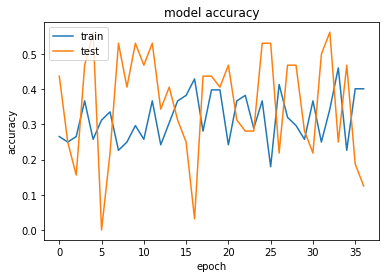

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is observed that the accuracy does not improve with epochs, which means that even if we train more, the model does not predict better.

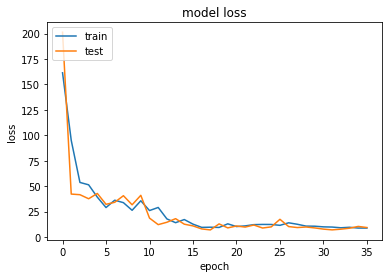

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the case of loss, it is observed that as the epochs increase, their value decreases, which is the objective. This loss is worse than the one obtained with VGG16 model.

In [ ]:
# Save the model
model = load_model('resnet50-100epoch-freeze.h5')

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred_class = y_pred.argmax(axis=1)

In [ ]:
y_real_class = y_real.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

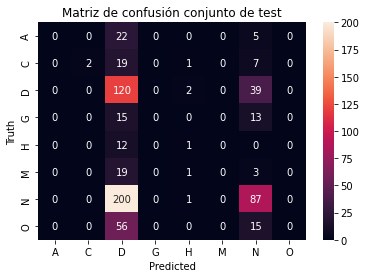

In [ ]:
labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']

cf_matrix = confusion_matrix(y_real_class, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

The confusion matrix shows that most of the predictions made by the model are classified as Diabetes (D) or Normal (N). It is overtrained.

In [ ]:
print(classification_report(y_real_class, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        27
           C       1.00      0.07      0.13        29
           D       0.26      0.75      0.38       161
           G       0.00      0.00      0.00        28
           H       0.17      0.08      0.11        13
           M       0.00      0.00      0.00        23
           N       0.51      0.30      0.38       288
           O       0.00      0.00      0.00        71

    accuracy                           0.33       640
   macro avg       0.24      0.15      0.12       640
weighted avg       0.35      0.33      0.28       640



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the results obtained, this model could not be put into production. 